<a href="https://colab.research.google.com/github/janduplessis883/project-nhs-gp-reviews/blob/master/GP_Review_Web_Scrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

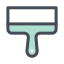

## Extracting **Surgery Name** and **ODE code** from Google Sheet


In [69]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('GP Surgeries England').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pd
gps = pd.DataFrame.from_records(rows)

In [70]:
gps.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,PCN member 1 Jan 22,Practice-code,Practice-Name,PCN Code Jan 22,PCN Name Jan 22,PCN Parent\nCCG Code Jan 22,PCN Parent\nCCG Name,Region (from April 22),Region (from April 22)2,ICS from April 22,ICS from April 223,Practice\nParent Jan 22\nCCG Code,Practice\nParent\nCCG Name,Practice CCG and PCN CCG Match,Raw list size from PCSE 1 Jan 22,PCN adjusted population I January 22
1,Yes,E81050,ASPLANDS MEDICAL CENTRE,U49574,ASCENT PCN,M1J4Y,"NHS BEDFORDSHIRE, LUTON AND MILTON KEYNES CCG",Y61,East of England,QHG,"NHS Bedfordshire, Luton and Milton Keynes ICB",M1J4Y,"NHS BEDFORDSHIRE, LUTON AND MILTON KEYNES CCG",TRUE,"12,232","11,505"


In [71]:
gps_short = gps[[1, 2]].copy()
gps_short.columns =["ode", "name"]
gps_short.drop(0, inplace=True)
gps_short['surgeryname'] = gps_short['name'].str.lower().str.replace(' ', '-')
gps_short.drop(columns='name', inplace=True)

In [72]:
gps_short.head(2)

,ode,surgeryname
1,E81050,asplands-medical-centre
2,K82064,fishermead-medical-centre


## URL Construtor

In [73]:
url_list = []
for index, row in gps_short.iterrows():
    ode = row['ode']  # Replace 'ode' with the actual column name for the ODE
    surgeryname = row['surgeryname']
    url = f"https://www.nhs.uk/services/gp-surgery/{surgeryname}/{ode}/ratings-and-reviews?currentpage=1"
    url_list.append(url)

gps_short['url'] = url_list


In [74]:
print(url_list[:5])
gps_short.head(2)

['https://www.nhs.uk/services/gp-surgery/asplands-medical-centre/E81050/ratings-and-reviews?currentpage=1', 'https://www.nhs.uk/services/gp-surgery/fishermead-medical-centre/K82064/ratings-and-reviews?currentpage=1', 'https://www.nhs.uk/services/gp-surgery/walnut-tree-health-centre/K82615/ratings-and-reviews?currentpage=1', 'https://www.nhs.uk/services/gp-surgery/ashburnham-road-surgery/E81615/ratings-and-reviews?currentpage=1', 'https://www.nhs.uk/services/gp-surgery/king-street-surgery/E81038/ratings-and-reviews?currentpage=1']


,ode,surgeryname,url
1,E81050,asplands-medical-centre,https://www.nhs.uk/services/gp-surgery/aspland...
2,K82064,fishermead-medical-centre,https://www.nhs.uk/services/gp-surgery/fisherm...


### Loading Google Sheet

In [75]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Open our new sheet and add some data.
worksheet = gc.open('NHS Choices Reviews').sheet1

# **Web Screpper**

In [ ]:
print("🏃‍♂️ Let's Scrape ")
from bs4 import BeautifulSoup
import time
import random
from ipywidgets import IntProgress, Label, HBox
from IPython.display import display

start = 1268
end = 3000
progress_bar = IntProgress(min=start, max=end)
progress_bar.style.bar_color = '#62899f'  # Set the color of the first progress bar
page_label = Label(value=f'Page: {start}')  # Initial label text

box = HBox([progress_bar, page_label])
display(box)

# Initialize the review progress bar and set its color
review_progress_bar = IntProgress(min=0, max=1)
review_progress_bar.style.bar_color = '#ae4f4d'  # Set the color of the second progress bar
display(review_progress_bar)
review_progress_bar.layout.visibility = 'hidden'

for index, row in gps_short[start:end].iterrows():
    # Update the progress bar
    progress_bar.value = index + 1  # Progress bar updates
    page_label.value = f'DF Index: {index + 1} of {end}'

    url = row['url']
    print(f"🔗 URL index {index} of {gps_short.shape[0]} - {url}", end='\r')
    random_sleep = random.uniform(0.1, 0.3)
    print(f'💤 Sleeping for {random_sleep:.2f} seconds', end='\r')
    time.sleep(random_sleep)

    # Send an HTTP GET request to the URL
    response = requests.get(url)

    # Check if the request was successful (HTTP status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the response
        html_content = response.text

        # Create a BeautifulSoup object to parse the HTML
        soup = BeautifulSoup(html_content, 'html.parser')

        # Find the <ol> tag with the role 'list' and class 'nhsuk-list'
        ol_reviews = soup.find('ol', {'role': 'list', 'class': 'nhsuk-list'})

        if ol_reviews:
            # Find all <li> tags within the ordered list with role 'listitem'
            review_blocks = ol_reviews.find_all('li', {'role': 'listitem'})

            review_progress_bar.max = len(review_blocks)
            review_progress_bar.value = 0
            review_progress_bar.layout.visibility = 'visible'

            for block in review_blocks:
                review_progress_bar.value += 1  # Update the progress bar for each block

                row_list = [index]
                ode = row['ode']
                surgeryname = row['surgeryname']
                url = row['url']

                row_list.append(ode)
                row_list.append(surgeryname)
                row_list.append(url)
                # Initialize variables
                title = ''
                star_rating = ''
                comment = ''
                visited_date = ''

                # Extract the title
                title_tag = block.find('h3', class_='nhsuk-body-l')
                title = title_tag.get_text(strip=True)
                title = title[13:]
                row_list.append(title)

                # Extract the star rating
                star_rating_tag = block.find('span', class_='stars stars--small')
                try:
                    star_rating = len(star_rating_tag.get_text(strip=True))
                    row_list.append(star_rating)
                except:
                    row_list.append(0)

                # Extract the comment
                comment_tag = block.find('p', class_='comment-text')
                comment = comment_tag.get_text(strip=True)
                row_list.append(comment)

                # Extract the visited date
                visited_date_tag = block.find('p', class_='nhsuk-body-s')
                visited_date = visited_date_tag.get_text(strip=True)
                row_list.append(visited_date)

                updated = worksheet.append_row(row_list)

            review_progress_bar.layout.visibility = 'hidden'
        else:
            print("⛔️ No review data found on the page.")

    else:
        print(f"❌ Failed to retrieve the page. Status code: {response.status_code}")

✅ Writing Rows 


IntProgress(value=0, max=1, style=ProgressStyle(bar_color='#ae4f4d'))

❌ Failed to retrieve the page. Status code: 404
⛔️ No review data found on the page.
❌ Failed to retrieve the page. Status code: 404
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
⛔️ No review data found on the page.
❌ Failed to retrieve the page. Status code: 404
⛔️ No review data found on the page.
⛔️ No review data found on the page.
❌ Failed to retrieve the page. Status code: 404
❌ Failed to retrieve the page. 